In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-images/train_images/train/0fbaf55ececd01a215a472856563d91c.jpg
/kaggle/input/train-images/train_images/train/7b24e0e060a831f94796f767b889ed81.jpg
/kaggle/input/train-images/train_images/train/5f9c52e7236f28b6729c700e6a106732.jpg
/kaggle/input/train-images/train_images/train/02dda2d04ccd708a6817e3a59affdeab.jpg
/kaggle/input/train-images/train_images/train/1fb6f3d35aed4f08f07bca98666c27b5.jpg
/kaggle/input/train-images/train_images/train/e20f1fc55ff3351c06672601b6b2adca.jpg
/kaggle/input/train-images/train_images/train/58bbe6b09c21a003e3f2048034df1123.jpg
/kaggle/input/train-images/train_images/train/d0ecd16721a5e9dbab6eed3ed2533e86.jpg
/kaggle/input/train-images/train_images/train/8df55dd1e4da9205c31bb738d31fae46.jpg
/kaggle/input/train-images/train_images/train/1d5550e35ca2b137bb52513ed89bfbdb.jpg
/kaggle/input/train-images/train_images/train/63e3b80de3c28a353421ac83ee85414b.jpg
/kaggle/input/train-images/train_images/train/ecd694b4f323f86f00cf9c8d6faa5448.jpg
/kag

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import cv2
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU,GlobalAveragePooling2D, Activation, Average,AveragePooling2D

from keras.optimizers import Adam,Adamax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [3]:
import os
seed = 42
np.random.seed(seed)

In [4]:
#base_dir = os.path.join("..", "input") # set base directory
train_df = pd.read_csv('../input/aerial-cactus-identification/train.csv')
train_dir = "../input/train-images/train_images/train"
test_dir = "../input/teat-images/test/test"

In [5]:
train_df['has_cactus'] = train_df['has_cactus'].astype(str)

batch_size = 64
train_size = 15750
validation_size = 1750

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
    #zoom_range =0.3,
    zca_whitening = False
    )

In [6]:
data_args = {
    "dataframe": train_df,
    "directory": train_dir,
    "x_col": 'id',
    "y_col": 'has_cactus',
    "featurewise_center" : True,
    "featurewise_std_normalization" : True,
    "samplewise_std_normalization" : False,
    "samplewise_center" : False,
    "shuffle": True,
    "target_size": (32, 32),
    "batch_size": batch_size,
    "class_mode": 'binary'
}

In [7]:
train_generator = datagen.flow_from_dataframe(**data_args, subset='training')
validation_generator = datagen.flow_from_dataframe(**data_args, subset='validation')

Found 15750 validated image filenames belonging to 2 classes.
Found 1750 validated image filenames belonging to 2 classes.


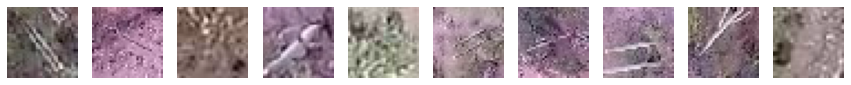

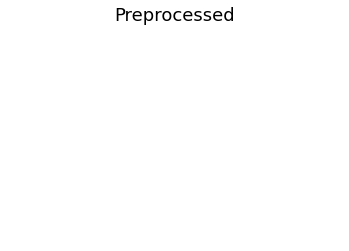

In [8]:
def show_image():
    f, ax = plt.subplots(1,10,figsize=(15,15))
    for i in range(10):
        image1 = next(train_generator)
        img1 = array_to_img(image1[0][0])
        ax[i].imshow(img1)
        ax[i].axis("off")
        
    plt.show()
    plt.axis("off")
    plt.title("Preprocessed", fontsize=18)

show_image()

In [9]:
def Le_Conv():
    model1 = Sequential()
    model1.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32, 32, 3), padding="same"))
    model1.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model1.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model1.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model1.add(Flatten())
    model1.add(Dense(84, activation='relu'))
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(optimizer =  Adamax(lr =0.001) , loss = "binary_crossentropy", metrics=["acc"])
    return model1

In [10]:
def VggNet_Model():
    model = Sequential()
    model.add(Conv2D(16, (2,2), activation="relu", input_shape=(32, 32, 3)))
    #model.add(LeakyReLU(alpha =0.3))
    model.add(Conv2D(16, (2,2), activation="relu"))
    model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha =0.3))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    model.add(Conv2D(32, (3,3), activation="relu"))
    #model.add(LeakyReLU(alpha =0.3))
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha =0.3))
    #model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3,3), activation="relu"))
    #model.add(LeakyReLU(alpha =0.3))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha =0.3))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    #model.add(Conv2D(128, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha =0.3))
    #model.add(Conv2D(128, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha =0.3))
    #model.add(MaxPooling2D(2,2))
    #model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(units=1, activation='sigmoid'))
    model.summary()
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, 
                 loss='binary_crossentropy',
                 metrics=['acc'])
    
    return model

In [11]:
def Custom_Conv():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
#model.add(LeakyReLU(alpha =0.3))
    model.add(Conv2D(32, (5,5), activation="relu"))
    model.add(BatchNormalization())
#model.add(LeakyReLU(alpha =0.3))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
#model.add(LeakyReLU(alpha =0.3))
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(BatchNormalization())
#model.add(LeakyReLU(alpha =0.3))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='sigmoid'))
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, 
                 loss='binary_crossentropy',
                 metrics=['acc'])
    return model

In [12]:
def Complex_model():
    model = Sequential()
        
    model.add(Conv2D(3, kernel_size = 3, activation = 'relu', input_shape = (32, 32, 3)))
    
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 32, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 128, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 2048, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dense(470, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation = 'tanh'))

    model.add(Dense(1, activation = 'sigmoid'))
    
    opt=Adam(0.001)
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return model

In [13]:
model = []
#model.append(VggNet_Model())
model.append(Custom_Conv())
model.append(Le_Conv())
model.append(Complex_model())

In [14]:
models = []
histories =[]

for i in range(len(model)):
    ckpt_path = 'aerial_cactus_detection_'+str(i)+'.hdf5'
    earlystop = EarlyStopping(monitor='val_acc', patience=25, verbose=1, restore_best_weights=False)
    reducelr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
    modelckpt_cb = ModelCheckpoint(ckpt_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    tb = TensorBoard()
    callbacks = [earlystop, reducelr, modelckpt_cb, tb]
    history = model[i].fit_generator(train_generator,
              validation_data=validation_generator,
              steps_per_epoch=train_size//batch_size,
              validation_steps=validation_size//batch_size,
              epochs=80, verbose=1, 
              shuffle=True,
              callbacks=callbacks)
    models.append(model[i])
    histories.append(history)

Epoch 1/80
246/246 [==============================] - ETA: 0s - loss: 0.1884 - acc: 0.9326
Epoch 00001: val_acc improved from -inf to 0.67419, saving model to aerial_cactus_detection_0.hdf5
246/246 [==============================] - 30s 120ms/step - loss: 0.1884 - acc: 0.9326 - val_loss: 0.7106 - val_acc: 0.6742
Epoch 2/80
245/246 [============================>.] - ETA: 0s - loss: 0.1026 - acc: 0.9629
Epoch 00002: val_acc did not improve from 0.67419
246/246 [==============================] - 11s 44ms/step - loss: 0.1026 - acc: 0.9629 - val_loss: 2.5004 - val_acc: 0.3235
Epoch 3/80
246/246 [==============================] - ETA: 0s - loss: 0.0997 - acc: 0.9648
Epoch 00003: val_acc improved from 0.67419 to 0.74016, saving model to aerial_cactus_detection_0.hdf5
246/246 [==============================] - 12s 48ms/step - loss: 0.0997 - acc: 0.9648 - val_loss: 4.0771 - val_acc: 0.7402
Epoch 4/80
246/246 [==============================] - ETA: 0s - loss: 0.0636 - acc: 0.9770
Epoch 00004: va

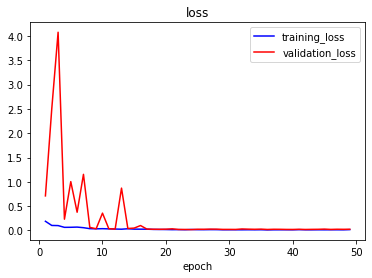

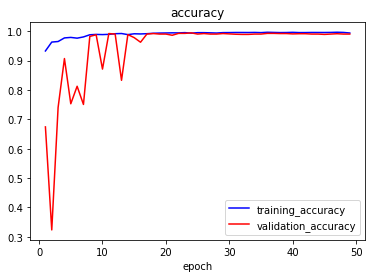

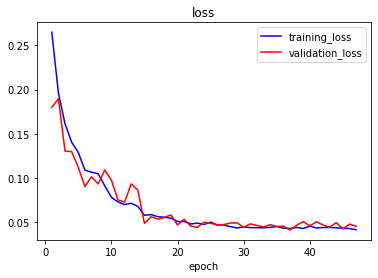

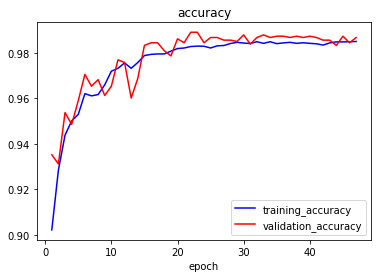

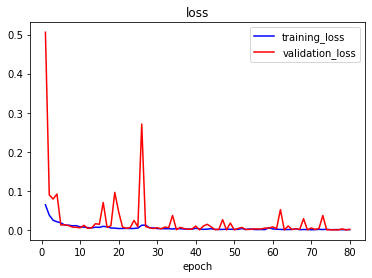

KeyError: 'acc'

In [15]:
for history in histories :
    epochs = [i for i in range(1, len(history.history['loss'])+1)]
    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.show()

In [16]:
test_df = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')
print(test_df.head())
test_images = []
images = test_df['id'].values

for image_id in images:
    test_images.append(cv2.imread(os.path.join(test_dir, image_id)))
    
test_images = np.asarray(test_images)
test_images = test_images / 255.0
print("Number of Test set images: " + str(len(test_images)))

                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg         0.5
1  0017242f54ececa4512b4d7937d1e21e.jpg         0.5
2  001ee6d8564003107853118ab87df407.jpg         0.5
3  002e175c3c1e060769475f52182583d0.jpg         0.5
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg         0.5
Number of Test set images: 4000


In [17]:
final_pred =[]
predictcustom = models[0].predict(test_images)
predictle = models[1].predict(test_images)
predictcomplex = models[2].predict(test_images)
#predict4 = models[3].predict(test_images)
stacked_arrays = np.hstack((predictcustom, predictle, predictcomplex)) #,predict4))
pred =np.mean(stacked_arrays, axis=1)
predweighted = 0.3*predictcustom +0.2*predictle + 0.5*predictcomplex

In [18]:
test_df['has_cactus'] = predweighted
#test_df['has_cactus1'] = labels
#test_df['has_cactus2'] = final_predict
test_df.to_csv('submission.csv', index = False)

In [19]:
test_df.head(5)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.999327
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999319
2,001ee6d8564003107853118ab87df407.jpg,0.168092
3,002e175c3c1e060769475f52182583d0.jpg,0.060396
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.999308
